In [1]:
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pl
%matplotlib inline
mpl.rcParams.update({'font.size':13})

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.io import votable
from astropy.utils import data
from astropy.io import fits
from astropy.wcs import WCS
data.conf.remote_timeout = 120 # default is 3 seconds
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore',category=AstropyWarning)
from astroquery.irsa_dust import IrsaDust

In [2]:
###### Variables to change ######
galfa = True # do galfahi sources or named sources
num_off_fields = 4 
search_rad = 2/60 # in degrees
big_rad = 10/60
distance=1000*np.linspace(10,1000,100) # default distance array is 10 kpc to 1 Mpc
col=('g','i')
mag='r'
phototype = 'MeanPSFMag'
errortype = 'MeanPSFMagErr'
num_stellar_pops = 1
num_stars_in_pop = 40000
num_population_draws = 10
stages = range(1,9)
#################################

# Stage | Type of star
# ---------------------
# 0      Pre-main sequence
# 1      Main Sequence
# 2      Sub giant branch
# 3      Red giant branch
# 4      Horizontal branch
# 5/6    Blue-ish giants (only present in youngest isochrone)
# 7      Asymptotic giant branch

# isochrone files
old_isochrones = ['t=10Gyr_Fe=-2.0.dat','t=5Gyr_Fe=-2.0.dat',
                  't=10Gyr_Fe=-1.5.dat','t=5Gyr_Fe=-1.5.dat',
                  't=10Gyr_Fe=-1.0.dat','t=5Gyr_Fe=-1.0.dat',]
young_isochrones = ['t=2Gyr_Fe=-2.0.dat','t=500Myr_Fe=-2.0.dat',
                    't=2Gyr_Fe=-1.5.dat','t=500Myr_Fe=-1.5.dat',
                    't=2Gyr_Fe=-1.0.dat','t=500Myr_Fe=-1.0.dat']

old_isocnames = [r'10Gyr, [Fe/H]$=-2.0$',r'5Gyr, [Fe/H]$=-2.0$',
                 r'10Gyr, [Fe/H]$=-1.5$',r'5Gyr, [Fe/H]$=-1.5$',
                 r'10Gyr, [Fe/H]$=-1.0$',r'5Gyr, [Fe/H]$=-1.0$',]
young_isocnames = [r'2Gyr, [Fe/H]$=-2.0$',r'0.5Gyr, [Fe/H]$=-2.0$',
                   r'2Gyr, [Fe/H]$=-1.5$',r'0.5Gyr, [Fe/H]$=-1.5$',
                   r'2Gyr, [Fe/H]$=-1.0$',r'0.5Gyr, [Fe/H]$=-1.0$',] 

# Named sources (for testing)
gals = ['Bootes_dSph','Bootes_II','Canes_Venatici_dSph',
        'Coma_Berenices','Draco_dSph','Hercules_dSph',
        'Leo_IV','Leo_V','Leo_T','Segue_1',
        'Ursa_Major_dSph','Ursa_Major_II','Willman_1_dSph']
gals_ned = ['Bootes+Dwarf','Bootes+II','Canes+Venatici+dSph',
            'Coma+Berenices','Draco+Dwarf','Hercules+Dwarf',
            'Leo+IV','Leo+V','Leo+T','Segue+1',
            'Ursa+Major+Dwarf','Ursa+Major+II','Willman+1']

# HI sources from galfahi
HIsources = Table.read('LeoT_like_sources_225cubes_ynm.csv',
                       format='csv')
HIcandidates = HIsources[HIsources['y/n/m'] == 'y']
HIcoords = SkyCoord(ra=HIcandidates['ra [deg]'],
                    dec=HIcandidates['dec [deg]'],
                    unit=u.deg,frame='icrs')

# Tables for main analysis 
names = gals
names_ned = gals_ned
path = 'plots/CMDs/'
if galfa:
    names = HIcandidates['id']
    names = names.astype(str)
    names_ned = ['']*len(names)
    path = 'plots/candidates/CMDs/'
cname0, cname1, mname = \
col[0]+phototype, col[1]+phototype, mag+phototype
cerr0, cerr1, merr = \
col[0]+errortype, col[1]+errortype, mag+errortype

## Set these manually if you don't want to do all sources in one go ##
#names = ['Leo_T']
#names_ned = ['Leo+T']
#isochrones = ['t=12Gyr_Fe=-1.5.dat','t=500Myr_Fe=-1.5.dat']
#isocnames = [r'12Gyr, [Fe/H]$=-1.5$',r'0.5Gyr, [Fe/H]$=-1.5$']
#names

In [3]:
## Functions to download and manipulate data ##

url_templ = 'http://gsss.stsci.edu/webservices/vo/CatalogSearch.aspx?'+\
            'CAT=PS1V3OBJECTS&RA={ra}&DEC={dec}&SR={rad}'
ned_template = 'https://ned.ipac.caltech.edu/cgi-bin/nDistance?name={name}'
img_name_template = 'http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?'+\
                    'ra={ra}&dec={dec}&filters={filters}'
img_download_template = 'http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?'+\
                        'format=fits&size={size}&red={name}&ra={ra}&dec={dec}'

def get_votable(ra=0,dec=0,radius=5/60,name=''):
    # ra, dec, radius must be in degrees
    if name != '':
        gal = SkyCoord.from_name(name)
        ra = gal.ra.deg
        dec = gal.dec.deg
    url = url_templ.format(ra=ra,dec=dec,rad=radius)
    tab = votable.parse_single_table(url).to_table()
    return tab

def get_field_coords(ra=0,dec=0,numoff=6,spacing=10/60,name=''):
    # ra, dec, spacing must be in degrees, numoff must be even
    assert numoff % 2 == 0, 'numoff is not even!'
    if name != '':
        source = SkyCoord.from_name(name)
    else:
        source = SkyCoord(ra=ra,dec=dec,unit=u.deg,frame='icrs')
    l, b = source.galactic.l, source.galactic.b
    l_near = np.arange(-numoff/2,numoff/2+1,1)*spacing
    l_near = np.roll(l_near,int(numoff/2+1))
    b_near = np.zeros(l_near.size)    
    l_tab = l + l_near*u.deg
    b_tab = b + b_near*u.deg
    lbs = SkyCoord(l=l_tab,b=b_tab,unit=u.deg,frame='galactic')
    radecs = SkyCoord(ra=lbs.icrs.ra,dec=lbs.icrs.dec,
                      unit=u.deg,frame='icrs')
    return radecs, b

def get_image_cutout(ra=0,dec=0,filters='g',size=1440):
    # "size" should be twice the search radius (1440 pixels = 6 arcmin)
    img_name = img_name_template.format(ra=ra,dec=dec,filters=filters)
    img_params = Table.read(data.download_file(img_name),
                            format='ascii')
    img_download = img_download_template.format(size=size,name=img_params['filename'][0],
                                                ra=ra,dec=dec)
    img_fits = data.download_file(img_download)

    return img_fits

def get_extinctions(ra=0,dec=0):
    coord = SkyCoord(ra=ra,dec=dec,unit=u.deg,frame='icrs')
    tab = IrsaDust.get_extinction_table(coord)
    return tab
    
def get_ned_distance(name=''):
    tab = []
    if name != '':
        ned_url = ned_template.format(name=name)
        tab = Table.read(ned_url,format='html')
    return tab

def select_stars(table,extinction):
    # (see https://confluence.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies)
    stars = table[table['iMeanPSFMag']-table['iMeanKronMag'] < 0.05]       
    stars = stars[(stars[mname] != -999)*\
                  (stars[cname0] != -999)*(stars[cname1] != -999)]
    stars = stars[(stars[merr] != -999)*\
                  (stars[cerr0] != -999)*(stars[cerr1] != -999)]
    stars[mname+'0'] = stars[mname] -\
                       extinction['A_SandF'][extinction['Filter_name'] == 'SDSS '+mag]
    stars[cname0+'0'] = stars[cname0] -\
                        extinction['A_SandF'][extinction['Filter_name'] == 'SDSS '+col[0]]            
    stars[cname1+'0'] = stars[cname1] -\
                        extinction['A_SandF'][extinction['Filter_name'] == 'SDSS '+col[1]]     
    return stars

In [4]:
## Functions to read in and manipulate of isochrone files ##

def load_isochrone(name='',stages=range(9)):
    isoc = []
    if name != '':
        isoc = Table.read('isochrones/'+name,format='ascii')
        isoc = Table(isoc,names=('metallicity','logage','M_ini','M_act',
                                 'logL/Lo','logTe','logG','mbol',
                                 'g','r','i','z','y','w','int_IMF','stage'))
        which_stages = (isoc['stage'] < 0)
        for s in stages:
            which_stages += (isoc['stage'] == s)
    return isoc[which_stages]


def get_int_IMF_diff(isochrone):
    int_IMF_diff = isochrone['int_IMF'][1:] - isochrone['int_IMF'][:-1]
#    int_IMF_diff = np.concatenate(([0],int_IMF_diff))
#    int_IMF_diff = np.zeros(9)
#    for s in range(9):
#        stage = np.where(isochrone['stage'] == s)[0]
#        if stage.size:
#            int_IMF_diff[s] = isochrone['int_IMF'][stage[-1]] -\
#                              isochrone['int_IMF'][stage[0]]
    return int_IMF_diff
        
def sample_isochrone(isochrone,numstars=2000):
    population = np.random.uniform(isochrone['int_IMF'].min(),
                                   isochrone['int_IMF'].max(),
                                   numstars)
    return population

def interpolate_params(isochrone,population,params=['g','r','i']):
    interpolated_vars = []
    if len(params) != 0:
        for param in params:
            interp_param = np.interp(population,
                                     isochrone['int_IMF'],isochrone[param])
            interpolated_vars.append(interp_param)
        interpolated_vars = Table(interpolated_vars,names=params)
    return interpolated_vars
    
def set_population_distance(interpolated_vars,distance,mag='r'):
    # distance given in pc
    if mag != '':
        distmodulus = 5*np.log10(distance/10)
        interpolated_vars[mag+'_new'] = interpolated_vars[mag] + distmodulus
    return interpolated_vars
       
def set_population_errors(interpolated_vars,real_stars,
                          mag='r_new',magbins=np.arange(16,24)):
    # real_stars should be a BIG field (e.g. 30 arcmin radius?)
    interpolated_vars['r_err'] = 0.
    interpolated_vars['g_err'] = 0.
    interpolated_vars['i_err'] = 0.
    for i in range(len(magbins)-1):
        # should I do the same thing for all magnitudes,
        # or use (e.g.) the median i mag in an rmag range?
        # does that even make sense?
        realstarsinrange = (real_stars[mname+'0'] > magbins[i])*\
                           (real_stars[mname+'0'] <= magbins[i+1])
        populationinrange = (interpolated_vars[mag] > magbins[i])*\
                            (interpolated_vars[mag] <= magbins[i+1])
        interpolated_vars['r_err'][populationinrange] = \
                np.median(real_stars[merr][realstarsinrange])
        interpolated_vars['g_err'][populationinrange] = \
                np.median(real_stars[cerr0][realstarsinrange])                           
        interpolated_vars['i_err'][populationinrange] = \
                np.median(real_stars[cerr1][realstarsinrange]) 
    return interpolated_vars

def set_population_detection(interpolated_vars,real_stars,
                             mag='r_new',magbins=np.linspace(16,23,50)):    
    hist, bins = np.histogram(real_stars[mname+'0'],bins=magbins)
    bins = (bins[1:] + bins[:-1])/2
    exp_index = (np.log10(hist[int(bins.size/2)])-np.log10(hist[0]))/\
                (magbins[int(bins.size/2)]-bins[0])
    normalization = hist[0]/10**(exp_index*bins[0])
    N_predicted = 10**(exp_index*bins)*normalization
    detection_probability = hist/N_predicted
    
    bin_inds = np.searchsorted(magbins,interpolated_vars[mag]) - 1
    bin_inds[bin_inds < 0] = 0
    bin_inds[bin_inds >= magbins.size-1 ] = magbins.size-2
    is_detected = np.random.uniform(size=interpolated_vars[mag].size)
    could_be_detected = detection_probability[bin_inds]
    interpolated_vars['detected'] = is_detected < could_be_detected
    return interpolated_vars

In [5]:
# Fit one or two stellar population(s) at a predetermined distance ##

def fit_population(table,detected_population1,detected_population2=[],
                   col=('g','i'),mag='r',phototype='MeanPSFMag',
                   errortype='MeanPSFMagErr'):
    numclosestars = 0.
    fracclosestars = 0.
    real_mag = table[mag+phototype]
    real_col = table[col[0]+phototype]-table[col[1]+phototype]
    real_magerr = table[mag+errortype]
    real_colerr = np.sqrt(table[col[0]+errortype]**2+table[col[1]+errortype]**2)   
    pop1_mag = detected_population1[mag+'_new']
    pop1_col = detected_population1[col[0]]-detected_population1[col[1]]
    pop1_magerr = detected_population1[mag+'_err']
    pop1_colerr = np.sqrt(detected_population1[col[0]+'_err']**2+\
                          detected_population1[col[1]+'_err']**2)
    pop1_weights = (np.mean(pop1_magerr) + np.mean(pop1_colerr))/(pop1_magerr+pop1_colerr)
    #totalpop = np.sum(pop1_weights)
    totalpop = pop1_mag.size
    realpop = np.zeros(real_mag.size)
    for i in range(pop1_mag.size):
        #point = np.array([pop_col[i],pop_mag[i]]).reshape(-1,1)
        close = np.where( (np.abs(pop1_col[i]-real_col) < pop1_colerr[i])*\
                          (np.abs(pop1_mag[i]-real_mag) < pop1_magerr[i]) )[0]
        realpop[close] += 1
        if close.size:
            numclosestars += 1#*pop1_weights[i]
    if detected_population2 != []:
        pop2_mag = detected_population2[mag+'_new']
        pop2_col = detected_population2[col[0]]-detected_population2[col[1]]
        pop2_magerr = detected_population2[mag+'_err']
        pop2_colerr = np.sqrt(detected_population2[col[0]+'_err']**2+\
                              detected_population2[col[1]+'_err']**2)   
        pop2_weights = (np.mean(pop2_magerr) + np.mean(pop2_colerr))/(pop2_magerr+pop2_colerr)
        #totalpop += np.sum(pop2_weights)
        totalpop += pop2_mag.size
        for j in range(pop2_mag.size):
            close = np.where( (np.abs(pop2_col[j]-real_col) < pop2_colerr[j])*\
                              (np.abs(pop2_mag[j]-real_mag) < pop2_magerr[j]) )[0]
            realpop[close] += 1
            if close.size:
                numclosestars += 1#*pop2_weights[j] 
    if totalpop:
        fracclosestars += numclosestars/totalpop
    fracrealstars = np.sum(realpop > 0)/real_mag.size
    return fracclosestars#+fracrealstars    


# Find best distance for a single instance of a stellar population ##

def find_distance(table,big_table,interpolated_vars1,interpolated_vars2=[],
                  distance=distance,col=('g','i'),mag='r',
                  phototype='MeanPSFMag',errortype='MeanPSFMagErr'):
    
    fracclosestars = np.zeros(distance.size)
    for i in range(distance.size):
        set_population_distance(interpolated_vars1,distance[i],mag=mag)
        set_population_errors(interpolated_vars1,big_table)
        set_population_detection(interpolated_vars1,big_table)
        detected_population1 = interpolated_vars1[interpolated_vars1['detected']]
        detected_population2 = []
        if interpolated_vars2 != []:
            set_population_distance(interpolated_vars2,distance[i],mag=mag)
            set_population_errors(interpolated_vars2,big_table)
            set_population_detection(interpolated_vars2,big_table)
            detected_population2 = interpolated_vars2[interpolated_vars2['detected']]
        fracclosestars[i] += fit_population(table,detected_population1,
                                            detected_population2=detected_population2,
                                            col=col,mag=mag,phototype=phototype,
                                            errortype=errortype)
    return fracclosestars

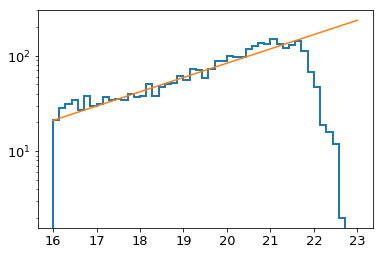

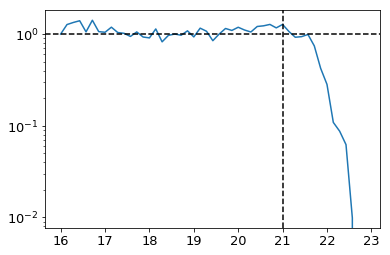

In [82]:
i=0
coords, gal_lat = get_field_coords(numoff=num_off_fields,
                                           spacing=10/60,name=names[i])
big_tab = get_votable(ra=coords[0].ra.deg,dec=coords[0].dec.deg,radius=10/60)
extinct = get_extinctions(ra=coords[0].ra.deg,dec=coords[0].dec.deg) 
big_star_tab = select_stars(big_tab,extinct)

f = pl.figure()
rmags = np.linspace(16,23,50)
starhist = pl.hist(big_star_tab[mname+'0'],histtype='step',bins=rmags,linewidth=2)
pl.gca().set_yscale('log')
slope = (np.log10(starhist[0][25])-np.log10(starhist[0][0]))/(starhist[1][25]-starhist[1][0])
powerlaw = 10**(slope*rmags)*starhist[0][0]/10**(slope*starhist[1][0])
pl.plot(rmags,powerlaw)
#pl.gca().invert_xaxis()

f1 = pl.figure()
pl.plot(rmags[:-1],starhist[0]/powerlaw[:-1])
pl.gca().set_yscale('log')
pl.axvline(x=21,color='black',linestyle='dashed')
pl.axhline(y=1,color='black',linestyle='dashed')

isoch = load_isochrone(name=young_isochrones[-1],stages=stages)
population = sample_isochrone(isoch,numstars=num_stars_in_pop*10)
interpolated_vars = interpolate_params(isoch,population)
set_population_distance(interpolated_vars,100*1000,mag=mag)
set_population_errors(interpolated_vars,big_star_tab)
set_population_detection(interpolated_vars,big_star_tab)
detected_population = interpolated_vars[interpolated_vars['detected']]   


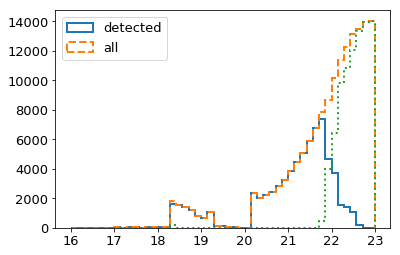

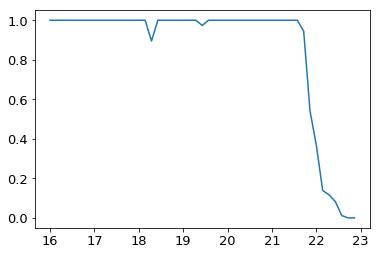

In [83]:
f2 = pl.figure()
starhist2 = pl.hist(detected_population[mag+'_new'],histtype='step',linewidth=2,bins=np.linspace(16,23,50),label='detected')
starhist3 = pl.hist(interpolated_vars[mag+'_new'],histtype='step',linewidth=2,bins=np.linspace(16,23,50),linestyle='dashed',label='all')
starhist4 = pl.hist(interpolated_vars[~interpolated_vars['detected']][mag+'_new'],histtype='step',linewidth=2,bins=np.linspace(16,23,50),linestyle='dotted')
#pl.gca().set_yscale('log')
pl.legend(loc='upper left')

#f3 = pl.figure(figsize=(6,6))
#pl.scatter(detected_population[col[0]]-detected_population[col[1]],
#           detected_population[mag+'_new'])
#pl.scatter(big_star_tab[cname0+'0']-big_star_tab[cname1+'0'],
#            big_star_tab[mname+'0'],s=25,alpha=0.5,marker='.',label='stars')
#pl.ylim(23,21)
#pl.gca().invert_yaxis()

f4 = pl.figure()
pl.plot(np.linspace(16,23,50)[:-1],starhist2[0]/starhist3[0])

In [ ]:
already_done = 70
for i in range(len(names)):
    if i < already_done:
        continue
    
    print(i,names[i],'...')
    
    # get coordinates of source, off-fields
    if galfa:
        coords, gal_lat = get_field_coords(ra=HIcoords[i].ra.deg,dec=HIcoords[i].dec.deg,
                                           numoff=num_off_fields,spacing=10/60)
    else:
        coords, gal_lat = get_field_coords(numoff=num_off_fields,
                                           spacing=10/60,name=names[i])

    # get distance to object from NED
    ned_tab = get_ned_distance(name=names_ned[i])
    if ned_tab != []:
        ned_dist = int(ned_tab['Metric Distance(Mpc)'][0] * 1000) # in kpc
    
    # get source data
    tab = get_votable(ra=coords[0].ra.deg,dec=coords[0].dec.deg,radius=search_rad)
    extinct = get_extinctions(ra=coords[0].ra.deg,dec=coords[0].dec.deg)    
    star_tab = select_stars(tab,extinct)

    # get large field data to set properties of population
    big_tab = get_votable(ra=coords[0].ra.deg,dec=coords[0].dec.deg,radius=big_rad)
    big_star_tab = select_stars(big_tab,extinct)
        
    # arrays for storing fit as function of distance
    numclosestars_object = np.zeros((num_population_draws,distance.size))
    numclosestars_controls = np.zeros((num_off_fields,distance.size))
    
    if num_stellar_pops == 1:
        # arrays for storing ave fit as function of distance - 1 population
        aveclosestars_object = np.zeros((len(old_isochrones),distance.size))
        stdclosestars_object = np.zeros((len(old_isochrones),distance.size))
        aveclosestars_controls = np.zeros((len(old_isochrones),distance.size))
        stdclosestars_controls = np.zeros((len(old_isochrones),distance.size))
        for j in range(len(old_isochrones)):
            print(j)
            # load isochrone
            isoch = load_isochrone(name=old_isochrones[j],stages=stages)

            # draw from isohrone a bunch of times to fit to source
            for k in range(num_population_draws):
                population = sample_isochrone(isoch,numstars=num_stars_in_pop)
                interpolated_vars = interpolate_params(isoch,population)
                numclosestars_object[k] = find_distance(star_tab,big_star_tab,
                                           interpolated_vars,distance=distance,
                                           phototype=phototype+'0',
                                           errortype=errortype)
            aveclosestars_object[j] = np.mean(numclosestars_object,axis=0)
            stdclosestars_object[j] = np.std(numclosestars_object,axis=0)
        
            # don't expect to detect anything in off-fields, so just use last drawn population
            for m in range(1,num_off_fields+1):
                tab = get_votable(ra=coords[m].ra.deg,dec=coords[m].dec.deg,radius=search_rad)
                extinct = get_extinctions(ra=coords[m].ra.deg,dec=coords[m].dec.deg)    
                control_star_tab = select_stars(tab,extinct)
                numclosestars_controls[m-1] = find_distance(control_star_tab,big_star_tab,
                                           interpolated_vars,distance=distance,
                                           phototype=phototype+'0',
                                           errortype=errortype)
            aveclosestars_controls[j] = np.mean(numclosestars_controls,axis=0)
            stdclosestars_controls[j] = np.std(numclosestars_controls,axis=0)
        
    elif num_stellar_pops == 2:
        # 24 pairs where the younger population has >= metallicity
        aveclosestars_object = np.zeros((24,distance.size))
        stdclosestars_object = np.zeros((24,distance.size))
        aveclosestars_controls = np.zeros((24,distance.size))
        stdclosestars_controls = np.zeros((24,distance.size))     
        numpairs = 0
        isocinds = np.zeros((24,2),dtype=int)
        for j in range(len(old_isochrones)):
            for y in range(len(young_isochrones)):
                if j % 2 == 0 and y < j:
                    continue
                elif j % 2 == 1 and y < j-1:
                    continue
                print(j,y)
                isocinds[numpairs] = (j, y)
                # load isochrones
                isoch1 = load_isochrone(name=old_isochrones[j],stages=stages)
                isoch2 = load_isochrone(name=young_isochrones[y],stages=stages)

                # draw from isohrones a bunch of times to fit to source
                for k in range(num_population_draws):
                    population1 = sample_isochrone(isoch1,numstars=int(num_stars_in_pop/2))
                    interpolated_vars1 = interpolate_params(isoch1,population1)
                    population2 = sample_isochrone(isoch2,numstars=int(num_stars_in_pop/2))
                    interpolated_vars2 = interpolate_params(isoch2,population2)
                
                    numclosestars_object[k] = find_distance(star_tab,big_star_tab,
                                           interpolated_vars1,interpolated_vars2=interpolated_vars2,
                                           distance=distance,
                                           phototype=phototype+'0',
                                           errortype=errortype)
                aveclosestars_object[numpairs] = np.mean(numclosestars_object,axis=0)
                stdclosestars_object[numpairs] = np.std(numclosestars_object,axis=0)
            
                # don't expect to detect anything in off-fields, so just use last drawn populations
                for m in range(1,num_off_fields+1):
                    tab = get_votable(ra=coords[m].ra.deg,dec=coords[m].dec.deg,radius=search_rad)
                    extinct = get_extinctions(ra=coords[m].ra.deg,dec=coords[m].dec.deg)    
                    control_star_tab = select_stars(tab,extinct)
                    numclosestars_controls[m-1] = find_distance(control_star_tab,big_star_tab,
                                           interpolated_vars1,interpolated_vars2=interpolated_vars2,
                                           distance=distance,
                                           phototype=phototype+'0',
                                           errortype=errortype)
                aveclosestars_controls[numpairs] = np.mean(numclosestars_controls,axis=0)
                stdclosestars_controls[numpairs] = np.std(numclosestars_controls,axis=0)
                numpairs += 1
  
    # get best distance and isochrone      
    bestdist = np.where(aveclosestars_object==np.max(aveclosestars_object))[1][0]
    bestisoc = np.where(aveclosestars_object==np.max(aveclosestars_object))[0][0]
    if num_stellar_pops == 1:
        # create population from best isochrone at best distance
        isoch = load_isochrone(name=old_isochrones[bestisoc],stages=stages)
        interpolated_vars = interpolate_params(isoch,population)
        set_population_distance(interpolated_vars,distance[bestdist],mag=mag)
        set_population_errors(interpolated_vars,big_star_tab)
        set_population_detection(interpolated_vars,big_star_tab)
        detected_population = interpolated_vars[interpolated_vars['detected']]   
    elif num_stellar_pops == 2:
        # get best isochrones                
        bestisoc1 = isocinds[np.where(aveclosestars_object==np.max(aveclosestars_object))[0][0]][0]
        bestisoc2 = isocinds[np.where(aveclosestars_object==np.max(aveclosestars_object))[0][0]][1]
        # create population from best isochrones at best distance
        isoch1 = load_isochrone(name=old_isochrones[bestisoc1],stages=stages)
        interpolated_vars1 = interpolate_params(isoch1,population1)
        set_population_distance(interpolated_vars1,distance[bestdist],mag=mag)
        set_population_errors(interpolated_vars1,big_star_tab)
        set_population_detection(interpolated_vars1,big_star_tab)
        detected_population1 = interpolated_vars1[interpolated_vars1['detected']]   
        isoch2 = load_isochrone(name=young_isochrones[bestisoc2],stages=stages)
        interpolated_vars2 = interpolate_params(isoch2,population2)
        set_population_distance(interpolated_vars2,distance[bestdist],mag=mag)
        set_population_errors(interpolated_vars2,big_star_tab)
        set_population_detection(interpolated_vars2,big_star_tab)
        detected_population2 = interpolated_vars2[interpolated_vars2['detected']]   
        
        
    # get fits image of source, image size = 2*search_red
    size = int(240*2*60*search_rad) # pixels
    imagefits = get_image_cutout(ra=coords[0].ra.deg,dec=coords[0].dec.deg,
                                 filters='g',size=size)
    image = fits.open(imagefits)
    #wcs = WCS(image[0].header)
    
    # set up CMD plot
    f = pl.figure(figsize=(8,8))
    ax1 = f.add_subplot(221)
    ax2 = f.add_subplot(222)
    ax3 = f.add_subplot(223)
    ax4 = f.add_subplot(224)
    ax4.axis('off')
    
    # plot fits image
    im2 = ax2.imshow(image[0].data,origin='lower',cmap=mpl.cm.gray,
                     interpolation='none',vmax=0.01*np.nanmax(image[0].data))
    ax2.set_xlabel('RA',fontsize=11)
    ax2.set_ylabel('Dec',fontsize=11)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_title('(RA, Dec) = ('+str(np.round(coords[0].ra.deg,2))+', '+\
                                  str(np.round(coords[0].dec.deg,2))+')',fontsize=11)
    ax2.axvline(x=np.float(coords[0].ra.deg)-2/3*search_rad,
                ymin=0.1,ymax=0.1+1/(size/240),linewidth=2,color='red')
    #f.colorbar(im2,ax=ax2)

    # Plot CMD with population at best distance
    ax1.scatter(star_tab[cname0+'0']-star_tab[cname1+'0'],
                star_tab[mname+'0'],s=25,alpha=0.5,marker='.',label='stars')
    ax1.errorbar(star_tab[cname0+'0']-star_tab[cname1+'0'],star_tab[mname+'0'],
                 xerr=np.sqrt(star_tab[cerr0]**2+star_tab[cerr1]**2),
                 yerr=star_tab[merr],alpha=0.2,fmt='.',label=errortype)
    ax1.set_xlim(-0.5,1.5)
    #ax1.set_xticks(np.arange(-0.5,2,0.5))
    ax1.set_ylim(16,23)
    ax1.set_yticks(np.arange(16,24))
    #ax1.set_xlabel(r'$g-i$')
    ax1.set_ylabel(r'$r$')
    ax1.invert_yaxis()
    if num_stellar_pops == 1:
        ax1.scatter(detected_population[col[0]]-detected_population[col[1]],
                    detected_population[mag+'_new'],s=25,alpha=1,marker='.',
                    label=old_isocnames[bestisoc])
        ax1.errorbar(detected_population[col[0]]-detected_population[col[1]],
                     detected_population[mag+'_new'],
                     xerr=np.sqrt(detected_population[col[0]+'_err']**2+\
                                  detected_population[col[1]+'_err']**2),
                     yerr=detected_population[mag+'_err'],alpha=1,fmt='.',label='')
    elif num_stellar_pops == 2:
        ax1.scatter(detected_population1[col[0]]-detected_population1[col[1]],
                    detected_population1[mag+'_new'],s=25,alpha=1,marker='.',
                    label=old_isocnames[bestisoc1])
        ax1.errorbar(detected_population1[col[0]]-detected_population1[col[1]],
                     detected_population1[mag+'_new'],
                     xerr=np.sqrt(detected_population1[col[0]+'_err']**2+\
                                  detected_population1[col[1]+'_err']**2),
                     yerr=detected_population1[mag+'_err'],alpha=1,fmt='.',label='')
        ax1.scatter(detected_population2[col[0]]-detected_population2[col[1]],
                    detected_population2[mag+'_new'],s=25,alpha=1,marker='.',
                    label=young_isocnames[bestisoc2])
        ax1.errorbar(detected_population2[col[0]]-detected_population2[col[1]],
                     detected_population2[mag+'_new'],
                     xerr=np.sqrt(detected_population2[col[0]+'_err']**2+\
                                  detected_population2[col[1]+'_err']**2),
                     yerr=detected_population2[mag+'_err'],alpha=1,fmt='.',label='')        
    ax1.legend(loc='upper left',fontsize=10)
    ax1.set_title(names[i]+r': $b=$'+str(np.round(gal_lat.deg,1))+r'$^{\circ}$')
    
    # Plot CMD with population of control field at best distance
    ax3.scatter(control_star_tab[cname0+'0']-control_star_tab[cname1+'0'],
                control_star_tab[mname+'0'],s=25,alpha=0.5,marker='.',label='stars')
    ax3.errorbar(control_star_tab[cname0+'0']-control_star_tab[cname1+'0'],
                 control_star_tab[mname+'0'],
                 xerr=np.sqrt(control_star_tab[cerr0]**2+control_star_tab[cerr1]**2),
                 yerr=control_star_tab[merr],alpha=0.2,fmt='.',label=errortype)
    ax3.set_xlim(-0.5,1.5)
    ax3.set_xticks(np.arange(-0.5,2,0.5))
    ax3.set_ylim(16,23)
    ax3.set_yticks(np.arange(16,24))
    ax3.set_xlabel(r'$g-i$')
    ax3.set_ylabel(r'$r$')
    ax3.invert_yaxis()
    if num_stellar_pops == 1:
        ax3.scatter(detected_population[col[0]]-detected_population[col[1]],
                    detected_population[mag+'_new'],s=25,alpha=0.5,marker='.',
                    label=old_isocnames[bestisoc])
        ax3.errorbar(detected_population[col[0]]-detected_population[col[1]],
                     detected_population[mag+'_new'],
                     xerr=np.sqrt(detected_population[col[0]+'_err']**2+\
                                  detected_population[col[1]+'_err']**2),
                     yerr=detected_population[mag+'_err'],alpha=0.5,fmt='.')
    elif num_stellar_pops == 2:
        ax3.scatter(detected_population1[col[0]]-detected_population1[col[1]],
                    detected_population1[mag+'_new'],s=25,alpha=0.5,marker='.',
                    label=old_isocnames[bestisoc1])
        ax3.errorbar(detected_population1[col[0]]-detected_population1[col[1]],
                     detected_population1[mag+'_new'],
                     xerr=np.sqrt(detected_population1[col[0]+'_err']**2+\
                                  detected_population1[col[1]+'_err']**2),
                     yerr=detected_population1[mag+'_err'],alpha=0.5,fmt='.',label='')
        ax3.scatter(detected_population2[col[0]]-detected_population2[col[1]],
                    detected_population2[mag+'_new'],s=25,alpha=0.5,marker='.',
                    label=old_isocnames[bestisoc2])
        ax3.errorbar(detected_population2[col[0]]-detected_population2[col[1]],
                     detected_population2[mag+'_new'],
                     xerr=np.sqrt(detected_population2[col[0]+'_err']**2+\
                                  detected_population2[col[1]+'_err']**2),
                     yerr=detected_population2[mag+'_err'],alpha=0.5,fmt='.',label='')        

    # save 3-paneled CMD figure
    pl.savefig(path+names[i]+'_CMD.pdf')
    pl.close(f)
    
    # plot fit results
    f2 = pl.figure()
    pl.fill_between(distance/1000,aveclosestars_object[bestisoc]-stdclosestars_object[bestisoc],
                    aveclosestars_object[bestisoc]+stdclosestars_object[bestisoc],
                    alpha=0.8,label=str(num_population_draws)+' population draws')
    pl.fill_between(distance/1000,aveclosestars_controls[bestisoc]-stdclosestars_controls[bestisoc],
                    aveclosestars_controls[bestisoc]+stdclosestars_controls[bestisoc],
                    alpha=0.5,label=str(num_off_fields)+' off-fields')
    pl.xlabel('Distance [kpc]')
    pl.ylabel('Overlapping population fraction')
    pl.axvline(x=distance[bestdist]/1000,linestyle='dotted',color='black',
               label=str(np.int(distance[bestdist]/1000))+' kpc')
    if ned_tab != []:
        pl.axvline(x=ned_dist,linestyle='dotted',color='red',label=str(ned_dist)+' kpc (NED)')
    pl.title(names[i])
    pl.legend()
    pl.gcf().subplots_adjust(left=0.15,bottom=0.15)
    pl.savefig(path+names[i]+'_fitresult.pdf')
    pl.close(f2)
    
    f3 = pl.figure()
    for k in range(6):
    #pl.fill_between(distance/1000,aveclosestars_object[i]-stdclosestars_object[i],
    #                aveclosestars_object[i]+stdclosestars_object[i],
    #                alpha=0.5)
        pl.plot(distance/1000,aveclosestars_object[k])
    pl.xlabel('Distance [kpc]')
    pl.ylabel('Overlapping population fraction')
    #pl.axvline(x=ned_dist,linestyle='dotted',color='red',label=str(ned_dist)+' kpc (NED)')
    pl.title(names[i])
    pl.legend()
    pl.gcf().subplots_adjust(left=0.15,bottom=0.15)
    pl.ylim(0,1)
    pl.savefig(path+names[i]+'_fitresults.pdf')
    pl.close(f3)
    
    f4 = pl.figure()
    for k in range(6):
    #pl.fill_between(distance/1000,aveclosestars_object[i]-stdclosestars_object[i],
    #                aveclosestars_object[i]+stdclosestars_object[i],
    #                alpha=0.5)
        pl.plot(distance/1000,aveclosestars_controls[k])
    pl.xlabel('Distance [kpc]')
    pl.ylabel('Overlapping population fraction')
    #pl.axvline(x=ned_dist,linestyle='dotted',color='red',label=str(ned_dist)+' kpc (NED)')
    pl.title(names[i])
    pl.legend()
    pl.gcf().subplots_adjust(left=0.15,bottom=0.15)
    pl.ylim(0,1)
    pl.savefig(path+names[i]+'_controlresults.pdf')
    pl.close(f4)


0 [ 450.]
2 [ 510.]
5 [ 550.]
11 [ 520.]
15 [ 520.]
19 [ 510.]
21 [ 520.]
23 [ 520.]


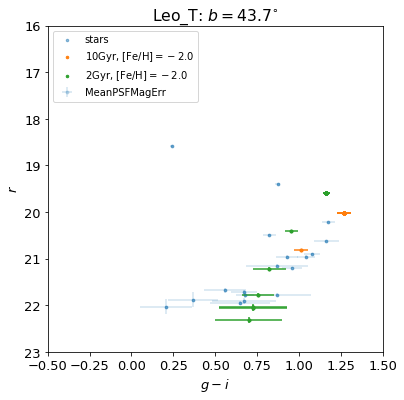

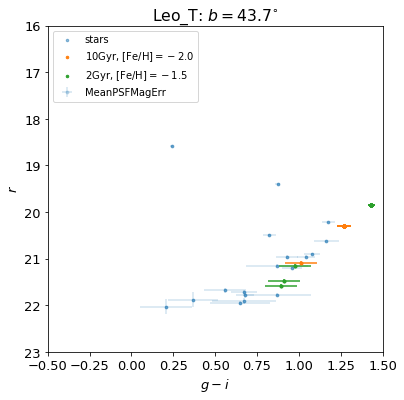

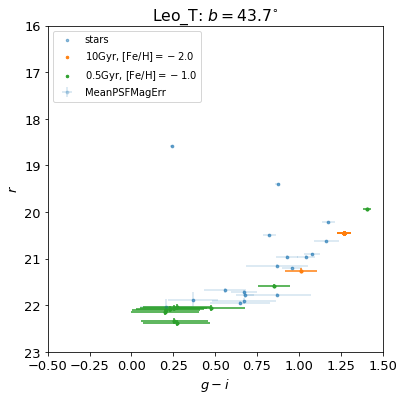

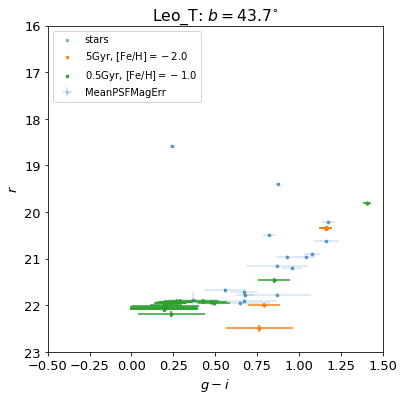

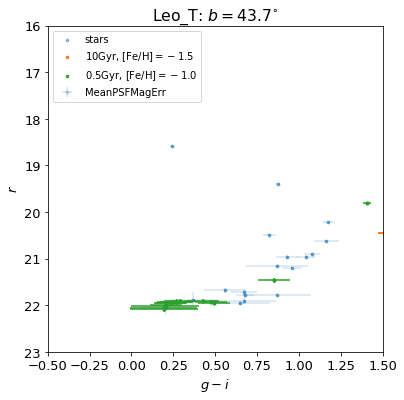

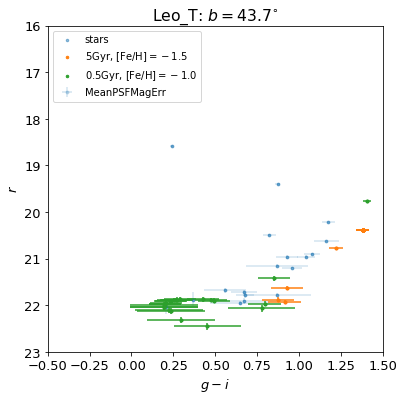

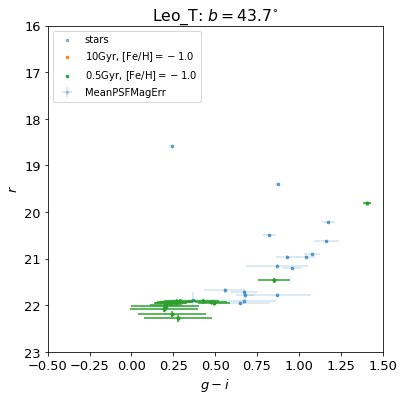

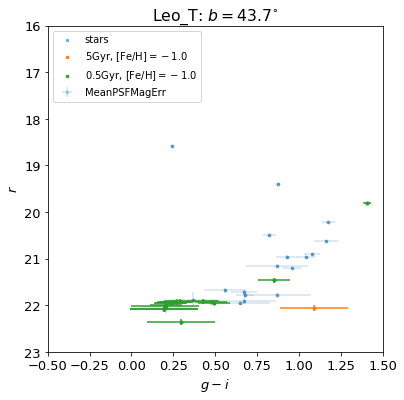

In [8]:
for k in range(24):
    #pl.fill_between(distance/1000,aveclosestars_object[i]-stdclosestars_object[i],
    #                aveclosestars_object[i]+stdclosestars_object[i],
    #                alpha=0.5)
    pl.plot(distance/1000,aveclosestars_object[k],linewidth=0.5)
pl.xlabel('Distance [kpc]')
pl.ylabel('Overlapping population fraction')
pl.axvline(x=ned_dist,linestyle='dotted',color='red',label=str(ned_dist)+' kpc (NED)')
pl.title(names[0])
pl.legend()
pl.gcf().subplots_adjust(left=0.15,bottom=0.15)
pl.savefig(path+names[i]+'_fitresults.pdf')
pl.close()

for k in range(24):
    bestdist = np.where(aveclosestars_object[k]==np.max(aveclosestars_object[k]))[0]
    if distance[bestdist]/1000 > 400 and distance[bestdist]/1000 < 600:
        print(k,distance[bestdist]/1000)
        leotdist = 412*1000
        bestisoc1 = isocinds[k][0]
        bestisoc2 = isocinds[k][1]
        isoch1 = load_isochrone(name=old_isochrones[bestisoc1],stages=stages)
        interpolated_vars1 = interpolate_params(isoch1,population1)
        set_population_distance(interpolated_vars1,distance[bestdist],mag=mag)
        set_population_errors(interpolated_vars1,big_star_tab)
        set_population_detection(interpolated_vars1,big_star_tab)
        detected_population1 = interpolated_vars1[interpolated_vars1['detected']]   
        isoch2 = load_isochrone(name=young_isochrones[bestisoc2],stages=stages)
        interpolated_vars2 = interpolate_params(isoch2,population2)
        set_population_distance(interpolated_vars2,distance[bestdist],mag=mag)
        set_population_errors(interpolated_vars2,big_star_tab)
        set_population_detection(interpolated_vars2,big_star_tab)
        detected_population2 = interpolated_vars2[interpolated_vars2['detected']]   

        pl.figure(figsize=(6,6))
        pl.scatter(star_tab[cname0+'0']-star_tab[cname1+'0'],
                star_tab[mname+'0'],s=25,alpha=0.5,marker='.',label='stars')
        pl.errorbar(star_tab[cname0+'0']-star_tab[cname1+'0'],star_tab[mname+'0'],
                 xerr=np.sqrt(star_tab[cerr0]**2+star_tab[cerr1]**2),
                 yerr=star_tab[merr],alpha=0.2,fmt='.',label=errortype)
        pl.xlim(-0.5,1.5)
    #ax1.set_xticks(np.arange(-0.5,2,0.5))
        pl.ylim(16,23)
        pl.yticks(np.arange(16,24))
    #ax1.set_xlabel(r'$g-i$')
        pl.ylabel(r'$r$')
        pl.xlabel(r'$g-i$')
        pl.gca().invert_yaxis()
       
    #if 
        pl.scatter(detected_population1[col[0]]-detected_population1[col[1]],
                    detected_population1[mag+'_new'],s=25,alpha=1,marker='.',
                    label=old_isocnames[bestisoc1])
        pl.errorbar(detected_population1[col[0]]-detected_population1[col[1]],
                     detected_population1[mag+'_new'],
                     xerr=np.sqrt(detected_population1[col[0]+'_err']**2+\
                                  detected_population1[col[1]+'_err']**2),
                     yerr=detected_population1[mag+'_err'],alpha=1,fmt='.',label='')
        pl.scatter(detected_population2[col[0]]-detected_population2[col[1]],
                    detected_population2[mag+'_new'],s=25,alpha=1,marker='.',
                    label=young_isocnames[bestisoc2])
        pl.errorbar(detected_population2[col[0]]-detected_population2[col[1]],
                     detected_population2[mag+'_new'],
                     xerr=np.sqrt(detected_population2[col[0]+'_err']**2+\
                                  detected_population2[col[1]+'_err']**2),
                     yerr=detected_population2[mag+'_err'],alpha=1,fmt='.',label='')        
        pl.legend(loc='upper left',fontsize=10)
        pl.title(names[i]+r': $b=$'+str(np.round(gal_lat.deg,1))+r'$^{\circ}$')
        pl.savefig(path+names[i]+'_CMD_'+str(k)+'.pdf')


In [88]:
## Do population fit for desired sources ##

for i in range(len(names)):
    print(names[i],'...')
    # get source coordinates and off-field coordinates
    if galfa:
        coords, gal_lat = get_field_coords(ra=HIcoords[i].ra.deg,dec=HIcoords[i].dec.deg,
                                           numoff=num_off_fields,spacing=10/60)
    else:
        coords, gal_lat = get_field_coords(numoff=num_off_fields,spacing=10/60,name=names[i])

    # get distance to object from NED
    ned_tab = get_ned_distance(name=names_ned[i])
    if ned_tab != []:
        ned_dist = int(ned_tab['Metric Distance(Mpc)'][0] * 1000) # in kpc
    
    # array for best fit function of distance
    closestars = np.zeros((len(coords),distance.size))
    
    # get fits image of source, image size = 2*search_red
    size = int(240*2*60*search_rad) # pixels
    imagefits = get_image_cutout(ra=coords[0].ra.deg,dec=coords[0].dec.deg,
                                 filters='g',size=size)
    image = fits.open(imagefits)
    #wcs = WCS(image[0].header)
    
    # set up CMD plot
    f = pl.figure(figsize=(8,8))
    ax1 = f.add_subplot(221)
    ax2 = f.add_subplot(222)
    ax3 = f.add_subplot(223)
    ax4 = f.add_subplot(224)

    # plot fits image
    im2 = ax2.imshow(image[0].data,origin='lower',cmap=mpl.cm.gray,
                     interpolation='none',vmax=0.01*np.nanmax(image[0].data))
    ax2.set_xlabel('RA',fontsize=11)
    ax2.set_ylabel('Dec',fontsize=11)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_title('(RA, Dec) = ('+str(np.round(coords[0].ra.deg,2))+', '+str(np.round(coords[0].dec.deg,2))+')',fontsize=11)
    ax2.axvline(x=np.float(coords[0].ra.deg)-2/3*search_rad,ymin=0.1,ymax=0.1+1/(size/240),linewidth=2,color='red')
    #f.colorbar(im2,ax=ax2)
    
    for j in range(len(coords)):
        
        big_tab = get_votable(ra=coords[j].ra.deg,dec=coords[j].dec.deg,radius=30/60)
        tab = get_votable(ra=coords[j].ra.deg,dec=coords[j].dec.deg,radius=search_rad)
        extinct = get_extinctions(ra=coords[j].ra.deg,dec=coords[j].dec.deg)
        
        big_star_tab = select_stars(big_tab,extinct)
        star_tab = select_stars(tab,extinct)
        
        # get votable for desired coordinate
 #       tab = get_votable(ra=coords[j].ra.deg,dec=coords[j].dec.deg,radius=search_rad)
    
        # separate stars from non-stars 
        # (see https://confluence.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies)
  #      star_tab = tab[tab['iMeanPSFMag']-tab['iMeanKronMag'] < 0.05]

        # only use stars with defined magnitudes and magstds (!= -999) 
   #     star_tab = star_tab[(star_tab[mname] != -999)*\
     #                       (star_tab[cname0] != -999)*(star_tab[cname1] != -999)]
    #    star_tab = star_tab[(star_tab[merr] != -999)*\
     #                       (star_tab[cerr0] != -999)*(star_tab[cerr1] != -999)]

        # correct for extinction
      #  extinct = get_extinctions(ra=coords[j].ra.deg,dec=coords[j].dec.deg)
      #  star_tab[mname+'0'] = star_tab[mname] -\
      #                        extinct['A_SandF'][extinct['Filter_name'] == 'SDSS '+mag]
      #  star_tab[cname0+'0'] = star_tab[cname0] -\
      #                         extinct['A_SandF'][extinct['Filter_name'] == 'SDSS '+col[0]]            
      #  star_tab[cname1+'0'] = star_tab[cname1] -\
    #                           extinct['A_SandF'][extinct['Filter_name'] == 'SDSS '+col[1]] 
        
        #star_tab = star_tab[(star_tab[mname] > 19)]
        
        if j == 0 and num_stellar_pops == 1:
            maxclosestars = np.zeros(len(old_isochrones))
            Nstarlist = []  
            for k in range(len(old_isochrones)):
                isoch = load_isochrone(name=old_isochrones[k],stages=stages)
                population = sample_isochrone(isoch,numstars=200000)
                interpolated_vars = interpolate_params(isoch,population)

                set_population_distance(interpolated_vars,400,mag='r')
                set_population_errors(interpolated_vars,stars)
                set_population_detection(interpolated_vars,stars)
                detected_population = interpolated_vars[interpolated_vars['detected']]

                
                
                
                # perform isochrone fits for a single "old" population

                
                    numclosestars = fit_isochrone(star_tab,isoc,
                                                  col=col,mag=mag,
                                                  phototype=phototype+'0',
                                                  errortype=errortype)
                    Nstarlist.append(numclosestars)
                    maxclosestars[k] = np.max(numclosestars)
                bestisoc_ind = np.where(maxclosestars == np.max(maxclosestars))[0][0]
                bestisoc = load_isochrone(name=old_isochrones[bestisoc_ind],
                                          stages=stages)
                # store best fit
                closestars[j] = Nstarlist[bestisoc_ind]
            elif num_stellar_pops == 2: 
                # perform two-isochrone fits for an "old" and "young" population simultaneously
                maxclosestars = np.zeros((len(old_isochrones),len(young_isochrones)))
                Nstarlist = [[] for _ in range(len(old_isochrones))]
                for k in range(len(old_isochrones)-2):
                    for l in range(len(young_isochrones)):
                        if k in [0,2] and l < k+2:
                            Nstarlist[k].append([])
                            continue
                        elif k in [1,3] and l < k+1:
                            Nstarlist[k].append([])
                            continue
                        if l in [2,4,6]:
                            Nstarlist[k].append([])
                            continue
                        print(k,l)
                        isoc1 = load_isochrone(name=old_isochrones[k],stages=stages)
                        isoc2 = load_isochrone(name=young_isochrones[l],stages=stages)#(3,4,5,6))
                        numclosestars = fit_two_isochrones(star_tab,isoc1,isoc2,
                                                           col=col,mag=mag,
                                                           phototype=phototype+'0',
                                                           errortype=errortype)
                        Nstarlist[k].append(numclosestars)
                        maxclosestars[k][l] = np.max(numclosestars)
                bestisoc_ind = np.where(maxclosestars == np.max(maxclosestars))
                bestisoc_old = load_isochrone(name=old_isochrones[bestisoc_ind[0][0]],
                                              stages=stages)
                bestisoc_young = load_isochrone(name=young_isochrones[bestisoc_ind[1][0]],
                                                stages=stages)
                # store best fit
                closestars[j] = Nstarlist[bestisoc_ind[0][0]][bestisoc_ind[1][0]]
            
            # find distance of object based on best fit   
            bestdist = distance[closestars[j]==np.max(closestars[j])][0]

            # Plot CMD with best-fit isochrone(s) 
            ax1.scatter(star_tab[cname0+'0']-star_tab[cname1+'0'],
                       star_tab[mname+'0'],s=25,alpha=0.5,marker='.',label='stars')
            ax1.errorbar(star_tab[cname0+'0']-star_tab[cname1+'0'],star_tab[mname+'0'],
                        xerr=np.sqrt(star_tab[cerr0]**2+star_tab[cerr1]**2),
                        yerr=star_tab[merr],alpha=0.2,fmt='.',label=errortype)
            ax1.set_xlim(-0.5,1.5)
            #ax1.set_xticks(np.arange(-0.5,2,0.5))
            ax1.set_ylim(16,23)
            ax1.set_yticks(np.arange(16,24))
            #ax1.set_xlabel(r'$g-i$')
            ax1.set_ylabel(r'$r$')
            ax1.invert_yaxis()
            if num_stellar_pops == 1:
                ax1.scatter(bestisoc[col[0]]-bestisoc[col[1]],
                           bestisoc[mag]+5*np.log10(bestdist/10),
                           s=15,alpha=1,label=old_isocnames[bestisoc_ind],
                           marker='^',color='C'+str(bestisoc_ind+1))
            elif num_stellar_pops == 2:
                ax1.scatter(bestisoc_old[col[0]]-bestisoc_old[col[1]],
                           bestisoc_old[mag]+5*np.log10(bestdist/10),
                           s=15,alpha=0.5,label=old_isocnames[bestisoc_ind[0][0]],
                           marker='^',color='C'+str(bestisoc_ind[0][0]+1))
                ax1.scatter(bestisoc_young[col[0]]-bestisoc_young[col[1]],
                           bestisoc_young[mag]+5*np.log10(bestdist/10),
                           s=15,alpha=0.5,label=young_isocnames[bestisoc_ind[1][0]],
                           marker='^',color='C'+str(bestisoc_ind[1][0]+1))
            ax1.legend(loc='upper left',fontsize=10)
            ax1.set_title(names[i]+r': $b=$'+str(np.round(gal_lat.deg,1))+r'$^{\circ}$')

        elif j > 0:    
            # perform isochrone fits on off-fields with bestisoc
            if num_stellar_pops == 1:
                closestars[j] = fit_isochrone(star_tab,bestisoc,
                                              col=col,mag=mag,
                                              phototype=phototype+'0',
                                              errortype=errortype)
            elif num_stellar_pops == 2:
                closestars[j] = fit_two_isochrones(star_tab,bestisoc_old,
                                                   bestisoc_young,col=col,mag=mag,
                                                   phototype=phototype+'0',
                                                   errortype=errortype)
            if j == 1:
                ax3.scatter(star_tab[cname0+'0']-star_tab[cname1+'0'],
                           star_tab[mname+'0'],s=25,alpha=0.5,marker='.',label='stars')
                ax3.errorbar(star_tab[cname0+'0']-star_tab[cname1+'0'],star_tab[mname+'0'],
                            xerr=np.sqrt(star_tab[cerr0]**2+star_tab[cerr1]**2),
                            yerr=star_tab[merr],alpha=0.2,fmt='.',label=errortype)
                ax3.set_xlim(-0.5,1.5)
                ax3.set_xticks(np.arange(-0.5,2,0.5))
                ax3.set_ylim(16,23)
                ax3.set_yticks(np.arange(16,24))
                ax3.set_xlabel(r'$g-i$')
                ax3.set_ylabel(r'$r$')
                ax3.invert_yaxis()
                if num_stellar_pops == 1:
                    ax3.scatter(bestisoc[col[0]]-bestisoc[col[1]],
                               bestisoc[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=old_isocnames[bestisoc_ind],
                               marker='^',color='C'+str(bestisoc_ind+1))
                elif num_stellar_pops == 2:
                    ax3.scatter(bestisoc_old[col[0]]-bestisoc_old[col[1]],
                               bestisoc_old[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=old_isocnames[bestisoc_ind[0][0]],
                               marker='^',color='C'+str(bestisoc_ind[0][0]+1))
                    ax3.scatter(bestisoc_young[col[0]]-bestisoc_young[col[1]],
                               bestisoc_young[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=young_isocnames[bestisoc_ind[1][0]],
                               marker='^',color='C'+str(bestisoc_ind[1][0]+1))
                
            if j == 10:
                ax4.scatter(star_tab[cname0+'0']-star_tab[cname1+'0'],
                           star_tab[mname+'0'],s=25,alpha=0.5,marker='.',label='stars')
                ax4.errorbar(star_tab[cname0+'0']-star_tab[cname1+'0'],star_tab[mname+'0'],
                            xerr=np.sqrt(star_tab[cerr0]**2+star_tab[cerr1]**2),
                            yerr=star_tab[merr],alpha=0.2,fmt='.',label=errortype)
                ax4.set_xlim(-0.5,1.5)
                ax4.set_xticks(np.arange(-0.5,2,0.5))
                ax4.set_ylim(16,23)
                #ax4.set_yticks(np.arange(16,24))
                ax4.set_xlabel(r'$g-i$')
                #ax4.set_ylabel(r'$r$')
                ax4.invert_yaxis()
                if num_stellar_pops == 1:
                    ax4.scatter(bestisoc[col[0]]-bestisoc[col[1]],
                               bestisoc[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=old_isocnames[bestisoc_ind],
                               marker='^',color='C'+str(bestisoc_ind+1))
                elif num_stellar_pops == 2:
                    ax4.scatter(bestisoc_old[col[0]]-bestisoc_old[col[1]],
                               bestisoc_old[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=old_isocnames[bestisoc_ind[0][0]],
                               marker='^',color='C'+str(bestisoc_ind[0][0]+1))
                    ax4.scatter(bestisoc_young[col[0]]-bestisoc_young[col[1]],
                               bestisoc_young[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=young_isocnames[bestisoc_ind[1][0]],
                               marker='^',color='C'+str(bestisoc_ind[1][0]+1))
    
    # save 4-paneled CMD figure
    pl.savefig(path+names[i]+'_CMD.pdf')
    pl.close(f)
    
    # plot fit results
    f2 = pl.figure()
    pl.plot(distance/1000,closestars[0],label='Source')
    offstd = np.std(closestars[1:],axis=0)
    offmean = np.mean(closestars[1:],axis=0)
    pl.fill_between(distance/1000,offmean-offstd,offmean+offstd,facecolor='C1',
                    alpha=0.5,label=str(num_off_fields)+' off-fields')
    pl.xlabel('Distance [kpc]')
    pl.ylabel('"Quality" of fit')
    pl.axvline(x=bestdist/1000,linestyle='dotted',color='black',
               label=str(np.int(bestdist/1000))+' kpc')
    if ned_tab != []:
        pl.axvline(x=ned_dist,linestyle='dotted',color='red',label=str(ned_dist)+' kpc (NED)')
    pl.title(names[i])
    pl.legend()
    pl.gcf().subplots_adjust(left=0.15,bottom=0.15)
    pl.savefig(path+names[i]+'_fitresult.pdf')
    pl.close(f2)

    # calculate "zscore" as function of distance
    #f3 = pl.figure()
    #pl.plot(distance/1000,(closestars[0]-offmean)/offstd)
    #pl.xlabel('Distance [kpc]')
    #pl.ylabel('"z-score" of fit')
    #pl.axvline(x=bestdist/1000,linestyle='dotted',color='black',
    #           label=str(np.int(bestdist/1000))+' kpc')
    #if ned_tab != []:
    #    pl.axvline(x=ned_dist,linestyle='dotted',color='red',label=str(ned_dist)+' kpc (NED)')
    #pl.title(names[i])
    #pl.legend()
    #pl.gcf().subplots_adjust(left=0.15,bottom=0.15)
    #pl.savefig(path+names[i]+'_zscore_'+errortype+'.pdf')
    #pl.close(f3)

Leo_T ...
0 3
0 5
1 3
1 5
2 5
3 5


In [ ]:
## Functions to fit stellar population -- NEED TO UPDATE WITH NEW FITTING PROCEDURE!! ##

def fit_isochrone(table,isochrone,distance=distance,
                  col=('g','i'),mag='r',phototype='MeanPSFMag',
                  errortype='MeanPSFMagErr'):
    distmodulus = 5*np.log10(distance/10)
    numclosestars = np.zeros(distance.size)
    magerr = table[mag+errortype]
    colerr = np.sqrt(table[col[0]+errortype]**2+table[col[1]+errortype]**2)
    weights = (np.mean(magerr) + np.mean(colerr))/(magerr+colerr)
    for j in range(distance.size):
        iso = np.array([isochrone[col[0]]-isochrone[col[1]],
                        isochrone[mag]+distmodulus[j]])
        for i in range(table[mag+phototype].size):
            point = np.array([table[col[0]+phototype][i]-table[col[1]+phototype][i],
                              table[mag+phototype][i]]).reshape(-1,1)
            close = np.where( (np.abs(point[1]-iso[1]) < magerr[i])*\
                              (np.abs(point[0]-iso[0]) < colerr[i]) )[0]
            if close.size:
                #which_stages = isochrone['stage'][close]
                numclosestars[j] += weights[i]*np.max((get_int_IMF_diff(isochrone)*\
                                                       2.5**(-isochrone[mag]))[close])#[which_stages])
    return numclosestars

def fit_two_isochrones(table,isochrone1,isochrone2,distance=distance,
                       col=('g','i'),mag='r',phototype='MeanPSFMag',
                       errortype='MeanPSFMagErr'):
    # default distance array is 10 kpc to 1 Mpc
    distmodulus = 5*np.log10(distance/10)
    numclosestars = np.zeros(distance.size)
    magerr = table[mag+errortype]
    colerr = np.sqrt(table[col[0]+errortype]**2+table[col[1]+errortype]**2)
    weights = (np.mean(magerr) + np.mean(colerr))/(magerr+colerr)
    for j in range(distance.size):
        iso1 = np.array([isochrone1[col[0]]-isochrone1[col[1]],
                         isochrone1[mag]+distmodulus[j]])
        iso2 = np.array([isochrone2[col[0]]-isochrone2[col[1]],
                         isochrone2[mag]+distmodulus[j]])
        for i in range(table[mag+phototype].size):
            point = np.array([table[col[0]+phototype][i]-table[col[1]+phototype][i],
                              table[mag+phototype][i]]).reshape(-1,1)
            close1 = np.where( (np.abs(point[1]-iso1[1]) < magerr[i])*\
                               (np.abs(point[0]-iso1[0]) < colerr[i]) )[0]
            close2 = np.where( (np.abs(point[1]-iso2[1]) < magerr[i])*\
                               (np.abs(point[0]-iso2[0]) < colerr[i]) )[0]
            #which_stages1 = isochrone1['stage'][close1]
            #which_stages2 = isochrone2['stage'][close2]
            most_likely1, most_likely2 = 0, 0
            if close1.size:
                most_likely1 = np.max((get_int_IMF_diff(isochrone1)*\
                                       2.5**(-isochrone1[mag]))[close1])#[which_stages1])
            if close2.size:
                most_likely2 = np.max((get_int_IMF_diff(isochrone2)*\
                                       2.5**(-isochrone2[mag]))[close2])#[which_stages2])
            numclosestars[j] += weights[i]*max(most_likely1,most_likely2)
    return numclosestars

In [109]:
colorrange = [-0.5, 0, 0.5, 1, 1.5]
for i in range(4):
    grid = stars[(stars[mname+'0'] < 22)*(stars[mname+'0'] > 21)]
    grid = grid[grid[cname0+'0']-grid[cname1+'0'] > colorrange[i]]
    grid = grid[grid[cname0+'0']-grid[cname1+'0'] < colorrange[i+1]]
    print(np.median(np.sqrt(grid[cerr0]**2+grid[cerr1]**2)),
         np.std(np.sqrt(grid[cerr0]**2+grid[cerr1]**2)))
    
    #print(np.median(grid[merr]),np.std(grid[merr]))

0.153974860907 0.0759751520303
0.117361366749 0.0696639900299
0.123703688383 0.070299302101
0.171802759171 0.0624834780785


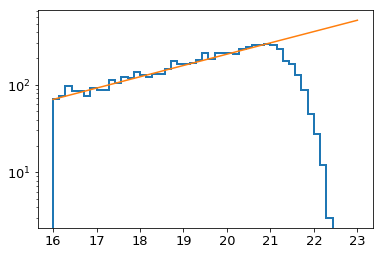

In [92]:
rmags = np.linspace(16,23,50)
starhist = pl.hist(stars[mname+'0'],histtype='step',bins=rmags,linewidth=2)
pl.gca().set_yscale('log')
slope = (np.log10(starhist[0][25])-np.log10(starhist[0][0]))/(starhist[1][25]-starhist[1][0])
powerlaw = 10**(slope*rmags)*starhist[0][0]/10**(slope*starhist[1][0])
pl.plot(rmags,powerlaw)
#pl.gca().invert_xaxis()

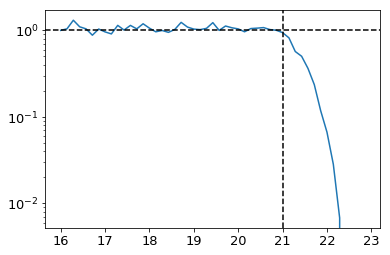

In [94]:
pl.plot(rmags[:-1],starhist[0]/powerlaw[:-1])
pl.gca().set_yscale('log')
pl.axvline(x=21,color='black',linestyle='dashed')
pl.axhline(y=1,color='black',linestyle='dashed')

In [83]:
## Older version of the stuff above, before I put things into functions ##

# define distance moduli
distance = 1000*np.linspace(10,500,100) # 10 to 500 kpc
distmod = 5*np.log10(distance/10)

# Find best-fit isochrone, once using MagStd, once using MagErr
numclosestars = np.zeros(distance.size)
for j in range(distance.size):
    for i in range(star_tab['rMeanPSFMag'].size):
        point = np.array([star_tab['gMeanPSFMag'][i]-star_tab['iMeanPSFMag'][i],
                          star_tab['rMeanPSFMag'][i]]).reshape(-1,1)
        iso = np.array([isoc15['g']-isoc15['i'],isoc15['r']+distmod[j]])
        if np.any( (np.abs(point[1]-iso[1]) < star_tab['rMeanPSFMagStd'][i])*(np.abs(point[0]-iso[0]) \
                        < np.sqrt(star_tab['gMeanPSFMagStd'][i]**2+star_tab['iMeanPSFMagStd'][i]**2)) ):
            numclosestars[j] += 1
            
numclosestars1 = np.zeros(distance.size)
for j in range(distance.size):
    for i in range(star_tab['rMeanPSFMag'].size):
        point = np.array([star_tab['gMeanPSFMag'][i]-star_tab['iMeanPSFMag'][i],
                          star_tab['rMeanPSFMag'][i]]).reshape(-1,1)
        iso = np.array([isoc15['g']-isoc15['i'],isoc15['r']+distmod[j]])
        if np.any( (np.abs(point[1]-iso[1]) < star_tab['rMeanPSFMagErr'][i])*(np.abs(point[0]-iso[0]) \
                        < np.sqrt(star_tab['gMeanPSFMagErr'][i]**2+star_tab['iMeanPSFMagErr'][i]**2)) ):
            numclosestars1[j] += 1

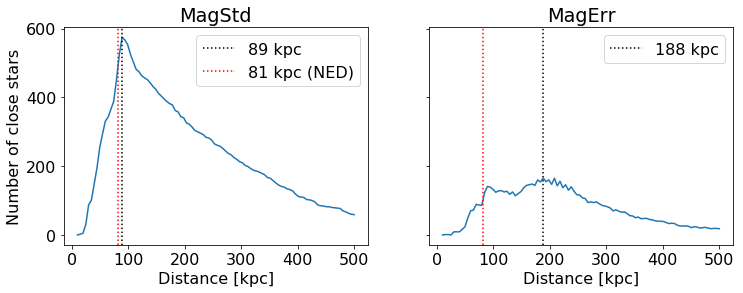

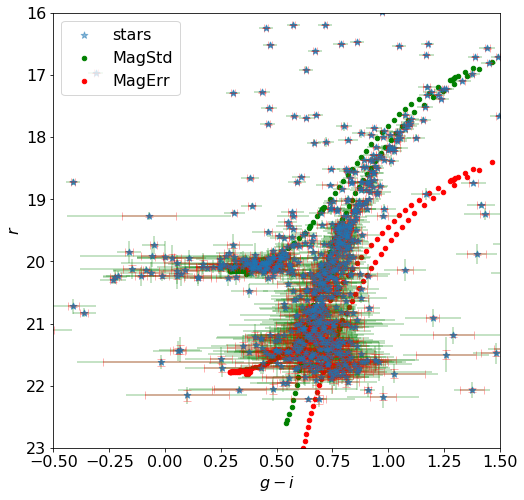

In [84]:
## Detailed plots comparing MagStd and MagErr ##

# Plot results of fit            
f, (ax1, ax2) = pl.subplots(1,2,sharex=True,sharey=True,figsize=(12,4))            
ax1.plot(distance/1000,numclosestars,label='')
ax1.set_xlabel('Distance [kpc]')
ax1.set_ylabel('Number of close stars')
bestdist = distance[numclosestars==numclosestars.max()][0]
ax1.axvline(x=bestdist/1000,linestyle='dotted',color='black',label=str(np.int(bestdist/1000))+' kpc')
ax1.axvline(x=81,linestyle='dotted',color='red',label='81 kpc (NED)')
ax1.set_title('MagStd')
ax1.legend()
ax2.plot(distance/1000,numclosestars1,label='')
ax2.set_xlabel('Distance [kpc]')
bestdist1 = distance[numclosestars1==numclosestars1.max()][0]
ax2.axvline(x=bestdist1/1000,linestyle='dotted',color='black',label=str(np.int(bestdist1/1000))+' kpc')
ax2.axvline(x=81,linestyle='dotted',color='red',label='')
ax2.set_title('MagErr')
ax2.legend()

# Galaxy CMD with best-fit isochrones
f = pl.figure(figsize=(8,8))
pl.scatter(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
           s=50,alpha=0.5,marker='*',label='stars')
pl.errorbar(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
            xerr=np.sqrt(star_tab['gMeanPSFMagStd']**2+star_tab['iMeanPSFMagStd'][i]**2),
            yerr=star_tab['rMeanPSFMagStd'],alpha=0.3,fmt='*',ecolor='green',label='')
pl.errorbar(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
            xerr=np.sqrt(star_tab['gMeanPSFMagErr']**2+star_tab['iMeanPSFMagErr'][i]**2),
            yerr=star_tab['rMeanPSFMagErr'],alpha=0.3,fmt='*',ecolor='red',capsize=4,label='')
pl.xlim(-0.5,1.5)
pl.ylim(16,23)
pl.xlabel(r'$g-i$')
pl.ylabel(r'$r$')
pl.gca().invert_yaxis()
pl.scatter(isoc15['g']-isoc15['i'],isoc15['r']+5*np.log10(bestdist/10),
           s=20,alpha=1,label='MagStd',marker='o',color='green')
pl.scatter(isoc15['g']-isoc15['i'],isoc15['r']+5*np.log10(bestdist1/10),
           s=20,alpha=1,label='MagErr',marker='o',color='red')
pl.legend(loc='upper left')